In [1]:
from model_trainer import *
from dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import normaltest, wilcoxon, ttest_ind

seed = 42

sns.set_theme(context="paper", style="white", palette="deep")

TRAIN_MODELS = False

/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_font_sizes(SMALL_SIZE=8, MEDIUM_SIZE=10, BIGGER_SIZE=12):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
scaler = 'minmax'
ds = {}
ds['A'] = Dataset('spinning_data.csv', scaler=scaler)
ds['B'] = Dataset('spinning_data_embeddings.csv', scaler=scaler)
#cv_type = 'kfold'
cv_type = 'groupkfold'
n_folds = 3
n_inner_folds = 5
mt = ModelTrainer(n_outer_folds=n_folds, n_inner_folds=n_inner_folds, cv_type=cv_type, random_state=seed)
models = {}
study_params = {
    'n_trails': 50,
    'timeout': 1800,
    'n_jobs': -1
}
targets = ds['A'].target_columns
targets_ordered = 'Strength (MPa)', 'Strain (mm/mm)', 'Toughness Modulus (MJ m-3)', 'Diameter (µm)', 'Youngs Modulus (GPa)'

/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/dataset.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0, 1.0, 1.0]
Length: 2190
Categories (2, float64): [1.0, 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[:, self.categorical_columns] = self._df.loc[:, self.categorical_columns].astype('category')
/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/dataset.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0, 1.0, 1.0]
Length: 2190
Categories (2, float64): [1.0, 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[:, self.categorical_columns] = self._df.loc[:, self.categorical_columns].ast

In [5]:
print(f'Number of rows: {len(ds['A'])}')
print(f'Number of columns: {len(ds['A'].columns)}')
print(f'Number of columns (PCA): {len(ds['B'].columns)}')
#print(ds['A'].df.loc[:,'Protein'].value_counts(normalize=True))
#print(ds['A'].df.loc[:,'Sample number'].value_counts(normalize=False).to_string())

Number of rows: 2190
Number of columns: 24
Number of columns (PCA): 39


In [5]:
if TRAIN_MODELS:
    for k in 'A', 'B':
        model_params = mt.hyperparameter_search(ds[k], study_name=k, **study_params)
        models[k] = mt.train_model(ds[k], model_params)
        for i, model in enumerate(models[k]):
            save_model(model, f'../models/model_{k}_fold_{i}')

In [6]:
for k in 'A', 'B':
    models[k] = [None] * n_folds
    for i in range(n_folds):
        models[k][i] = load_model(f'../models/model_{k}_fold_{i}')
        models[k][i].estimator.categorical_features = ds[k].categorical_columns

In [7]:
k = 'A'
for i in range(n_folds):
    print(models[k][i].get_params())

{'estimator__categorical_features': ['Capillery type', 'Spinning device', 'Number of baths', 'Continous spinning', 'Extrusion device', 'Spinning Buffer', 'Protein'], 'estimator__early_stopping': False, 'estimator__interaction_cst': None, 'estimator__l2_regularization': 0.5358117843786431, 'estimator__learning_rate': 0.026615291581774583, 'estimator__loss': 'squared_error', 'estimator__max_bins': 255, 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_iter': 107, 'estimator__max_leaf_nodes': 13, 'estimator__min_samples_leaf': 18, 'estimator__monotonic_cst': None, 'estimator__n_iter_no_change': 10, 'estimator__quantile': None, 'estimator__random_state': 42, 'estimator__scoring': 'loss', 'estimator__tol': 1e-07, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': HistGradientBoostingRegressor(categorical_features=['Capillery type',
                                                    'Spinning device',
    

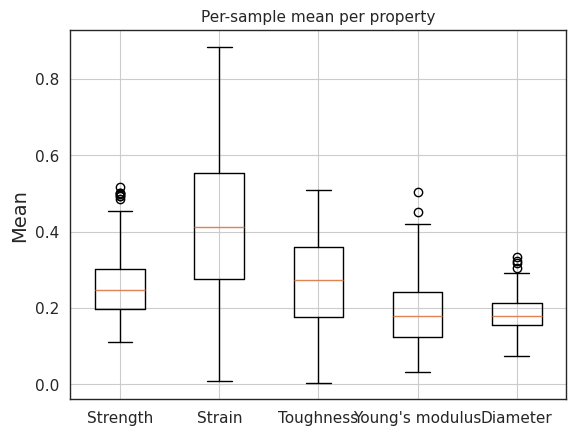

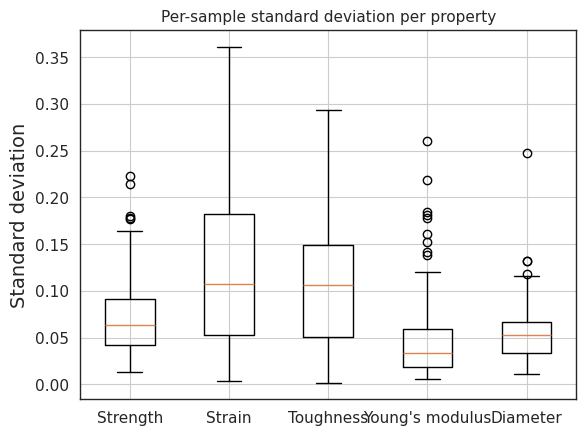

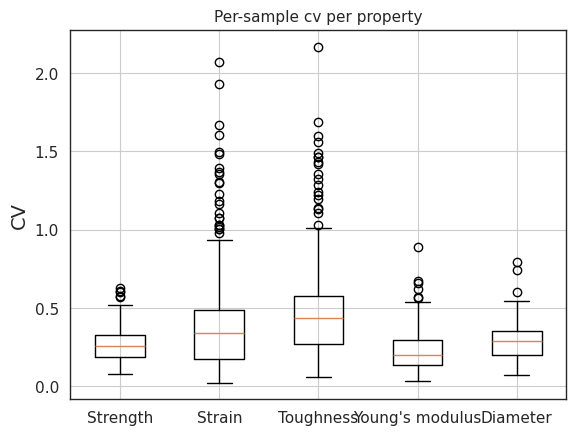

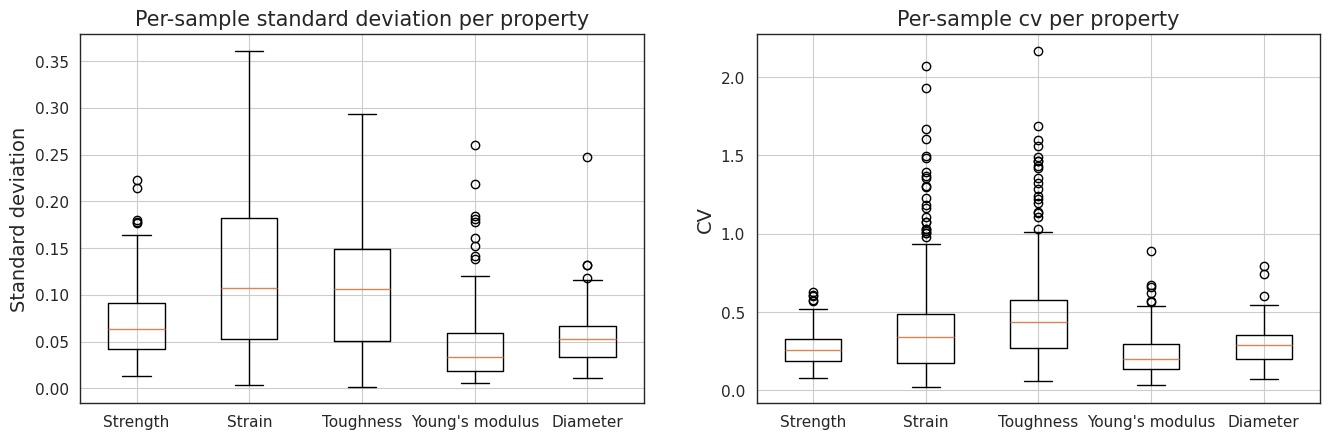

In [71]:
df_means = pd.DataFrame()
df_stds = pd.DataFrame()
df_cvs = pd.DataFrame()

df = ds['A'].group_samples()

for i in range(len(df)):
    if len(df.iloc[i, -1]) == 1: 
        continue
    sample = df.at[i, 'Sample number']
    df_means.at[i, 'Sample number'] = sample
    df_stds.at[i, 'Sample number'] = sample
    df_cvs.at[i, 'Sample number'] = sample
    for col in df.iloc[:, -5:].columns:
        df_means.at[i, col] = np.mean(df.at[i, col])
        df_stds.at[i, col] = np.std(df.at[i, col], ddof=1)
        df_cvs.at[i, col] = df_stds.at[i, col] / df_means.at[i, col]

target_names = 'Strength', 'Strain', 'Toughness', "Young's modulus", 'Diameter', 

set_font_sizes(11, 14, 20)

fig, ax = plt.subplots()
ax.boxplot(df_means.loc[:, targets_ordered], tick_labels=target_names)
ax.set_title("Per-sample mean per property")
ax.set_ylabel("Mean")
ax.grid(True)
plt.show()
fig.savefig('../figures/data_means')

fig, ax = plt.subplots()
ax.boxplot(df_stds.loc[:, targets_ordered], tick_labels=target_names)
ax.set_title("Per-sample standard deviation per property")
ax.set_ylabel("Standard deviation")
ax.grid(True)
plt.show()
fig.savefig('../figures/data_stds')

fig, ax = plt.subplots()
ax.boxplot(df_cvs.loc[:, targets_ordered], tick_labels=target_names)
ax.set_title("Per-sample cv per property")
ax.set_ylabel("CV")
ax.grid(True)
plt.show()
fig.savefig('../figures/data_cvs')

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(16)
'''
ax[0].boxplot(df_means.loc[:, targets_ordered], tick_labels=target_names)
ax[0].set_title("Per-sample mean per property", fontsize=15)
ax[0].set_ylabel("Mean")
ax[0].grid(True)
'''
ax[0].boxplot(df_stds.loc[:, targets_ordered], tick_labels=target_names)
ax[0].set_title("Per-sample standard deviation per property", fontsize=15)
ax[0].set_ylabel("Standard deviation")
ax[0].grid(True)
ax[1].boxplot(df_cvs.loc[:, targets_ordered], tick_labels=target_names)
ax[1].set_title("Per-sample cv per property", fontsize=15)
ax[1].set_ylabel("CV")
ax[1].grid(True)

plt.show()
fig.savefig('../figures/label_noise.png', bbox_inches='tight')

In [8]:
metrics = {}
metrics_tot = {}
metrics_mean = {}
metrics_std = {}

X = {}
X_tot = {}
Y_true = [None] * n_folds
Y_pred = {}
Y_true_tot = pd.DataFrame()
Y_pred_tot = {}
for k in 'A', 'B':
    X_, Y = ds[k]()
    X[k] = [None] * n_folds
    metrics[k] = [None] * n_folds
    Y_pred[k] = [None] * n_folds
    for fold, (train_idx, test_idx) in enumerate(mt._outer_cv.split(X_, groups=ds[k].sample_numbers.to_numpy())):
        X[k][fold] = X_.iloc[test_idx].copy()
        Y_true[fold] = Y.iloc[test_idx].copy()
        Y_pred[k][fold] = models[k][fold].predict(X_.iloc[test_idx].copy())
        metrics[k][fold] = compute_metrics(Y_true[fold], Y_pred[k][fold])
    X_tot[k] = pd.DataFrame(data=np.vstack(X[k]), columns=X_.columns)
    Y_true_tot = pd.DataFrame(data=np.vstack(Y_true), columns=Y.columns)
    Y_pred_tot[k] = pd.DataFrame(data=np.vstack(Y_pred[k]), columns=Y.columns)
    metrics_tot[k] = compute_metrics(Y_true_tot, Y_pred_tot[k])
    metrics_mean[k] = pd.DataFrame(np.array(metrics[k]).mean(axis=0), index=metrics[k][0].index, columns=metrics[k][0].columns)
    metrics_std[k] = pd.DataFrame(np.array(metrics[k]).std(axis=0, ddof=1), index=metrics[k][0].index, columns=metrics[k][0].columns)

In [9]:
metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075816,0.210384,0.098670,0.070883,0.156149
MAE,0.050536,0.161301,0.070845,0.052791,0.120265
$R^2$,0.515603,0.351730,0.250484,0.054926,0.188137
PCC,0.718113,0.593213,0.506631,0.261661,0.445117


In [10]:
metrics_tot['B']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075279,0.210839,0.097235,0.071071,0.156429
MAE,0.049744,0.158782,0.070394,0.052856,0.119214
$R^2$,0.522444,0.348923,0.272132,0.049887,0.185219
PCC,0.724928,0.592057,0.528111,0.264678,0.448362


In [11]:
metrics_tot['B'] - metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,-0.000537,0.000455,-0.001435,0.000189,0.000280
MAE,-0.000792,-0.002519,-0.000451,0.000065,-0.001051
$R^2$,0.006842,-0.002807,0.021647,-0.005039,-0.002919
PCC,0.006814,-0.001156,0.021479,0.003016,0.003244


In [12]:
100 * (metrics_tot['B'] - metrics_tot['A']) / metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,-0.708708,0.216228,-1.454648,0.266235,0.179588
MAE,-1.567204,-1.561841,-0.636675,0.123398,-0.873706
$R^2$,1.326913,-0.797917,8.642064,-9.174098,-1.551329
PCC,0.948934,-0.194867,4.239658,1.152811,0.728868


In [13]:
(metrics_mean['A'].map(lambda x: '{:.3E}'.format(x)) + ' ± ' + metrics_std['A'].map(lambda x: '{:.3E}'.format(x))).loc[:, targets_ordered].T

,RMSE,MAE,$R^2$,PCC
Strength (MPa),9.869E-02 ± 4.815E-03,7.092E-02 ± 3.144E-03,2.375E-01 ± 1.072E-01,4.916E-01 ± 1.024E-01
Strain (mm/mm),2.100E-01 ± 1.118E-02,1.612E-01 ± 7.792E-03,3.503E-01 ± 6.902E-02,5.944E-01 ± 6.086E-02
Toughness Modulus (MJ m-3),1.561E-01 ± 2.317E-03,1.202E-01 ± 3.242E-03,1.877E-01 ± 2.375E-02,4.486E-01 ± 3.098E-02
Diameter (µm),7.577E-02 ± 2.024E-03,5.061E-02 ± 4.042E-03,5.060E-01 ± 7.022E-02,7.164E-01 ± 4.579E-02
Youngs Modulus (GPa),7.078E-02 ± 4.579E-03,5.280E-02 ± 2.318E-03,4.622E-02 ± 8.964E-02,2.565E-01 ± 1.064E-01


In [14]:
(metrics_mean['B'].map(lambda x: '{:.2E}'.format(x)) + ' ± ' + metrics_std['B'].map(lambda x: '{:.2E}'.format(x))).loc[:, targets_ordered].T

,RMSE,MAE,$R^2$,PCC
Strength (MPa),9.72E-02 ± 4.53E-03,7.05E-02 ± 2.87E-03,2.61E-01 ± 8.22E-02,5.17E-01 ± 7.56E-02
Strain (mm/mm),2.10E-01 ± 1.18E-02,1.59E-01 ± 8.12E-03,3.48E-01 ± 7.33E-02,5.94E-01 ± 6.38E-02
Toughness Modulus (MJ m-3),1.56E-01 ± 2.40E-03,1.19E-01 ± 4.66E-03,1.85E-01 ± 2.85E-02,4.51E-01 ± 4.28E-02
Diameter (µm),7.52E-02 ± 2.30E-03,4.98E-02 ± 4.13E-03,5.13E-01 ± 6.67E-02,7.26E-01 ± 3.45E-02
Youngs Modulus (GPa),7.10E-02 ± 3.76E-03,5.29E-02 ± 1.66E-03,3.88E-02 ± 9.78E-02,2.58E-01 ± 1.07E-01


In [15]:
print(metrics_mean['A'].to_latex())
print(metrics_mean['B'].to_latex())
print((metrics_mean['B'] - metrics_mean['A']).to_latex())
print((100 * (metrics_mean['B'] - metrics_mean['A']) / metrics_mean['A']).to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Diameter (µm) & Strain (mm/mm) & Strength (MPa) & Youngs Modulus (GPa) & Toughness Modulus (MJ m-3) \\
\midrule
RMSE & 0.075772 & 0.209952 & 0.098687 & 0.070776 & 0.156095 \\
MAE & 0.050610 & 0.161178 & 0.070920 & 0.052796 & 0.120191 \\
$R^2$ & 0.506026 & 0.350327 & 0.237527 & 0.046217 & 0.187694 \\
PCC & 0.716412 & 0.594404 & 0.491650 & 0.256481 & 0.448576 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
 & Diameter (µm) & Strain (mm/mm) & Strength (MPa) & Youngs Modulus (GPa) & Toughness Modulus (MJ m-3) \\
\midrule
RMSE & 0.075228 & 0.210349 & 0.097232 & 0.071003 & 0.156361 \\
MAE & 0.049821 & 0.158626 & 0.070460 & 0.052864 & 0.119103 \\
$R^2$ & 0.513375 & 0.347695 & 0.261430 & 0.038756 & 0.184837 \\
PCC & 0.726189 & 0.593709 & 0.516656 & 0.258229 & 0.450555 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
 & Diameter (µm) & Strain (mm/mm) & Strength (MPa) & Youngs Modulus (GPa) & Toughness Modulus (MJ m-3) \\
\midrule


In [17]:
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
mapper = dict(zip(targets_ordered, target_names))
print((metrics_mean['A'].map(lambda x: '{:.2E}'.format(x)) + ' ± ' + metrics_std['A'].map(lambda x: '{:.2E}'.format(x))).loc[:, targets_ordered].rename(columns=mapper).T.to_latex())
print((metrics_mean['B'].map(lambda x: '{:.2E}'.format(x)) + ' ± ' + metrics_std['B'].map(lambda x: '{:.2E}'.format(x))).loc[:, targets_ordered].rename(columns=mapper).T.to_latex())

\begin{tabular}{lllll}
\toprule
 & RMSE & MAE & $R^2$ & PCC \\
\midrule
Strength & 9.87E-02 ± 4.82E-03 & 7.09E-02 ± 3.14E-03 & 2.38E-01 ± 1.07E-01 & 4.92E-01 ± 1.02E-01 \\
Strain & 2.10E-01 ± 1.12E-02 & 1.61E-01 ± 7.79E-03 & 3.50E-01 ± 6.90E-02 & 5.94E-01 ± 6.09E-02 \\
Toughness & 1.56E-01 ± 2.32E-03 & 1.20E-01 ± 3.24E-03 & 1.88E-01 ± 2.37E-02 & 4.49E-01 ± 3.10E-02 \\
Diameter & 7.58E-02 ± 2.02E-03 & 5.06E-02 ± 4.04E-03 & 5.06E-01 ± 7.02E-02 & 7.16E-01 ± 4.58E-02 \\
Young's modulus & 7.08E-02 ± 4.58E-03 & 5.28E-02 ± 2.32E-03 & 4.62E-02 ± 8.96E-02 & 2.56E-01 ± 1.06E-01 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & RMSE & MAE & $R^2$ & PCC \\
\midrule
Strength & 9.72E-02 ± 4.53E-03 & 7.05E-02 ± 2.87E-03 & 2.61E-01 ± 8.22E-02 & 5.17E-01 ± 7.56E-02 \\
Strain & 2.10E-01 ± 1.18E-02 & 1.59E-01 ± 8.12E-03 & 3.48E-01 ± 7.33E-02 & 5.94E-01 ± 6.38E-02 \\
Toughness & 1.56E-01 ± 2.40E-03 & 1.19E-01 ± 4.66E-03 & 1.85E-01 ± 2.85E-02 & 4.51E-01 ± 4.28E-02 \\
Diameter & 7.52E-02 ± 2.

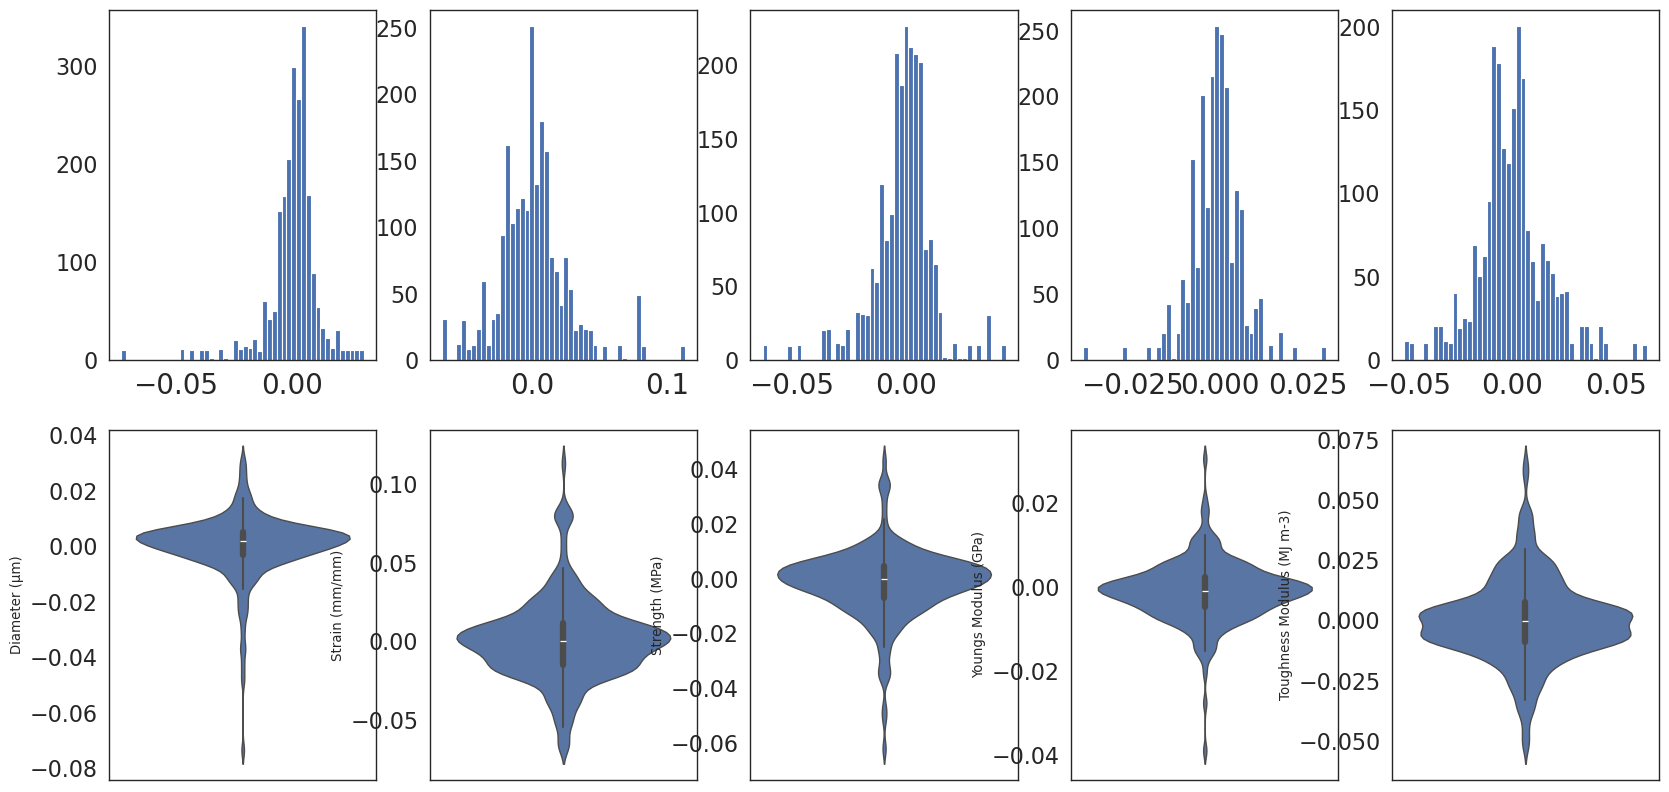

NormaltestResult(statistic=array([1062.47883332,  308.34263279,  376.34770989,  273.08788642,
        122.20429682]), pvalue=array([1.93042430e-231, 1.10725595e-067, 1.89292392e-082, 5.00862972e-060,
       2.90853378e-027]))
TtestResult(statistic=array([ 0.0410011 ,  0.16387873, -0.84893451, -1.36669061, -0.01343568]), pvalue=array([0.96729689, 0.86983418, 0.39596415, 0.17179248, 0.98928081]), df=array([4378., 4378., 4378., 4378., 4378.]))
WilcoxonResult(statistic=array([ 979325., 1178739., 1069558.,  951418., 1137339.]), pvalue=array([9.91874779e-14, 4.81465867e-01, 1.11753365e-05, 5.07536076e-17,
       3.54816709e-02]))


In [76]:
fig, ax = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(10)
diff = Y_pred_tot['A'] - Y_pred_tot['B']
for i in range(5):
    ax[0][i].hist(diff.iloc[:, i], bins=50)
    sns.violinplot(ax=ax[1][i], data=diff.iloc[:, i], bw_method='scott')
plt.show()
print(normaltest(Y_pred_tot['A'] - Y_pred_tot['B']))

result = ttest_ind(Y_pred_tot['A'], Y_pred_tot['B'])
print(result)

print(wilcoxon(Y_pred_tot['A'], Y_pred_tot['B']))

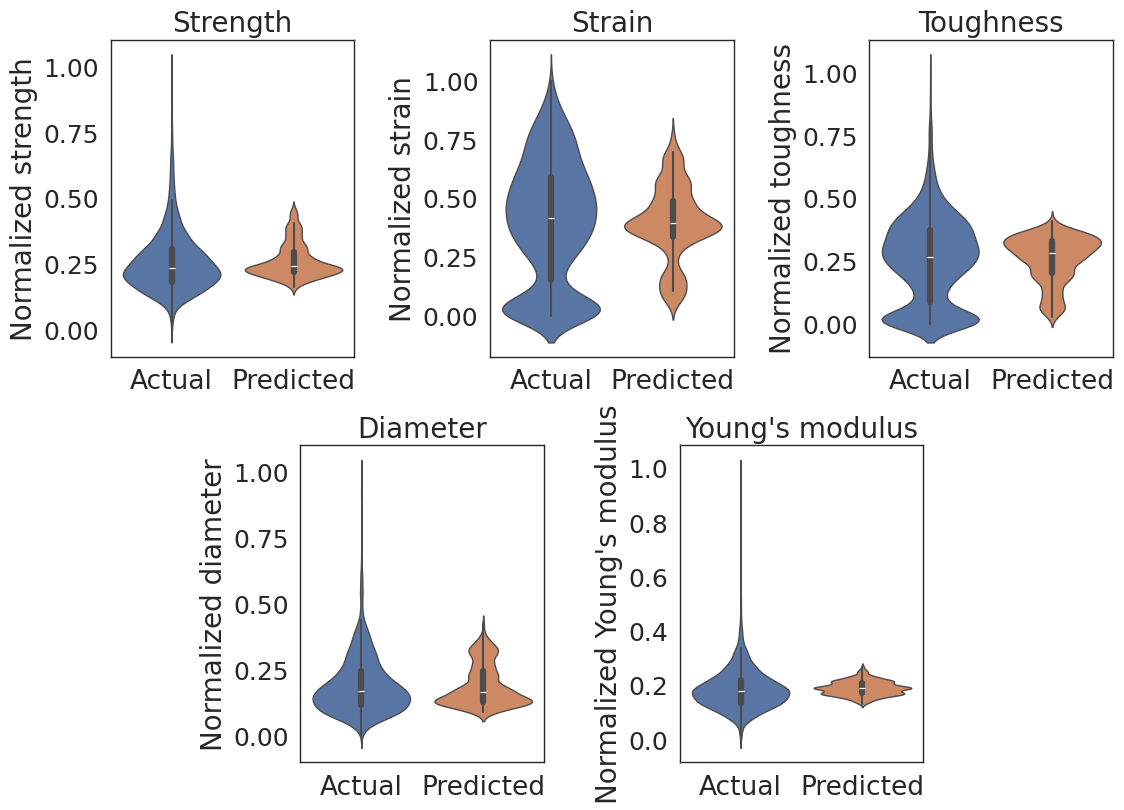

In [63]:
orientation = 'horizontal'
palettes = [None, ['g', 'm']]

if orientation == 'vertical':
    fig = plt.figure(figsize=(8,11))
    ax = [plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2),
        plt.subplot2grid((3,4), (0,2), colspan=2),
        plt.subplot2grid((3,4), (1,0), colspan=2),
        plt.subplot2grid((3,4), (1,2), colspan=2),
        plt.subplot2grid((3,4), (2,1), colspan=2)]
else:
    fig = plt.figure(figsize=(11,8))
    ax = [plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2),
        plt.subplot2grid((2,6), (0,2), colspan=2),
        plt.subplot2grid((2,6), (0,4), colspan=2),
        plt.subplot2grid((2,6), (1,1), colspan=2),
        plt.subplot2grid((2,6), (1,3), colspan=2)]

#set_font_sizes(12, 18)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.tight_layout(w_pad=5, h_pad=3)
k = 'A'
target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
for i, target in enumerate(targets_ordered):
    df = pd.DataFrame(data=np.vstack((Y_true_tot.loc[:, target].to_numpy(), Y_pred_tot[k].loc[:, target].to_numpy())).T,\
        columns=('Actual', 'Predicted'))
    ax[i].set_ylabel(f'Normalized {target_names[i]}')
    ax[i].set_title((lambda s: s[0].upper() + s[1:])(target_names[i]), fontsize=20)
    ax[i].xaxis.set_tick_params(labelsize=19)
    ax[i].yaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.label.set_fontsize(20)
    sns.violinplot(ax=ax[i], data=df, bw_method='scott', palette=palettes[0])

fig.savefig(f'../figures/distribution.png', bbox_inches='tight')
plt.show()

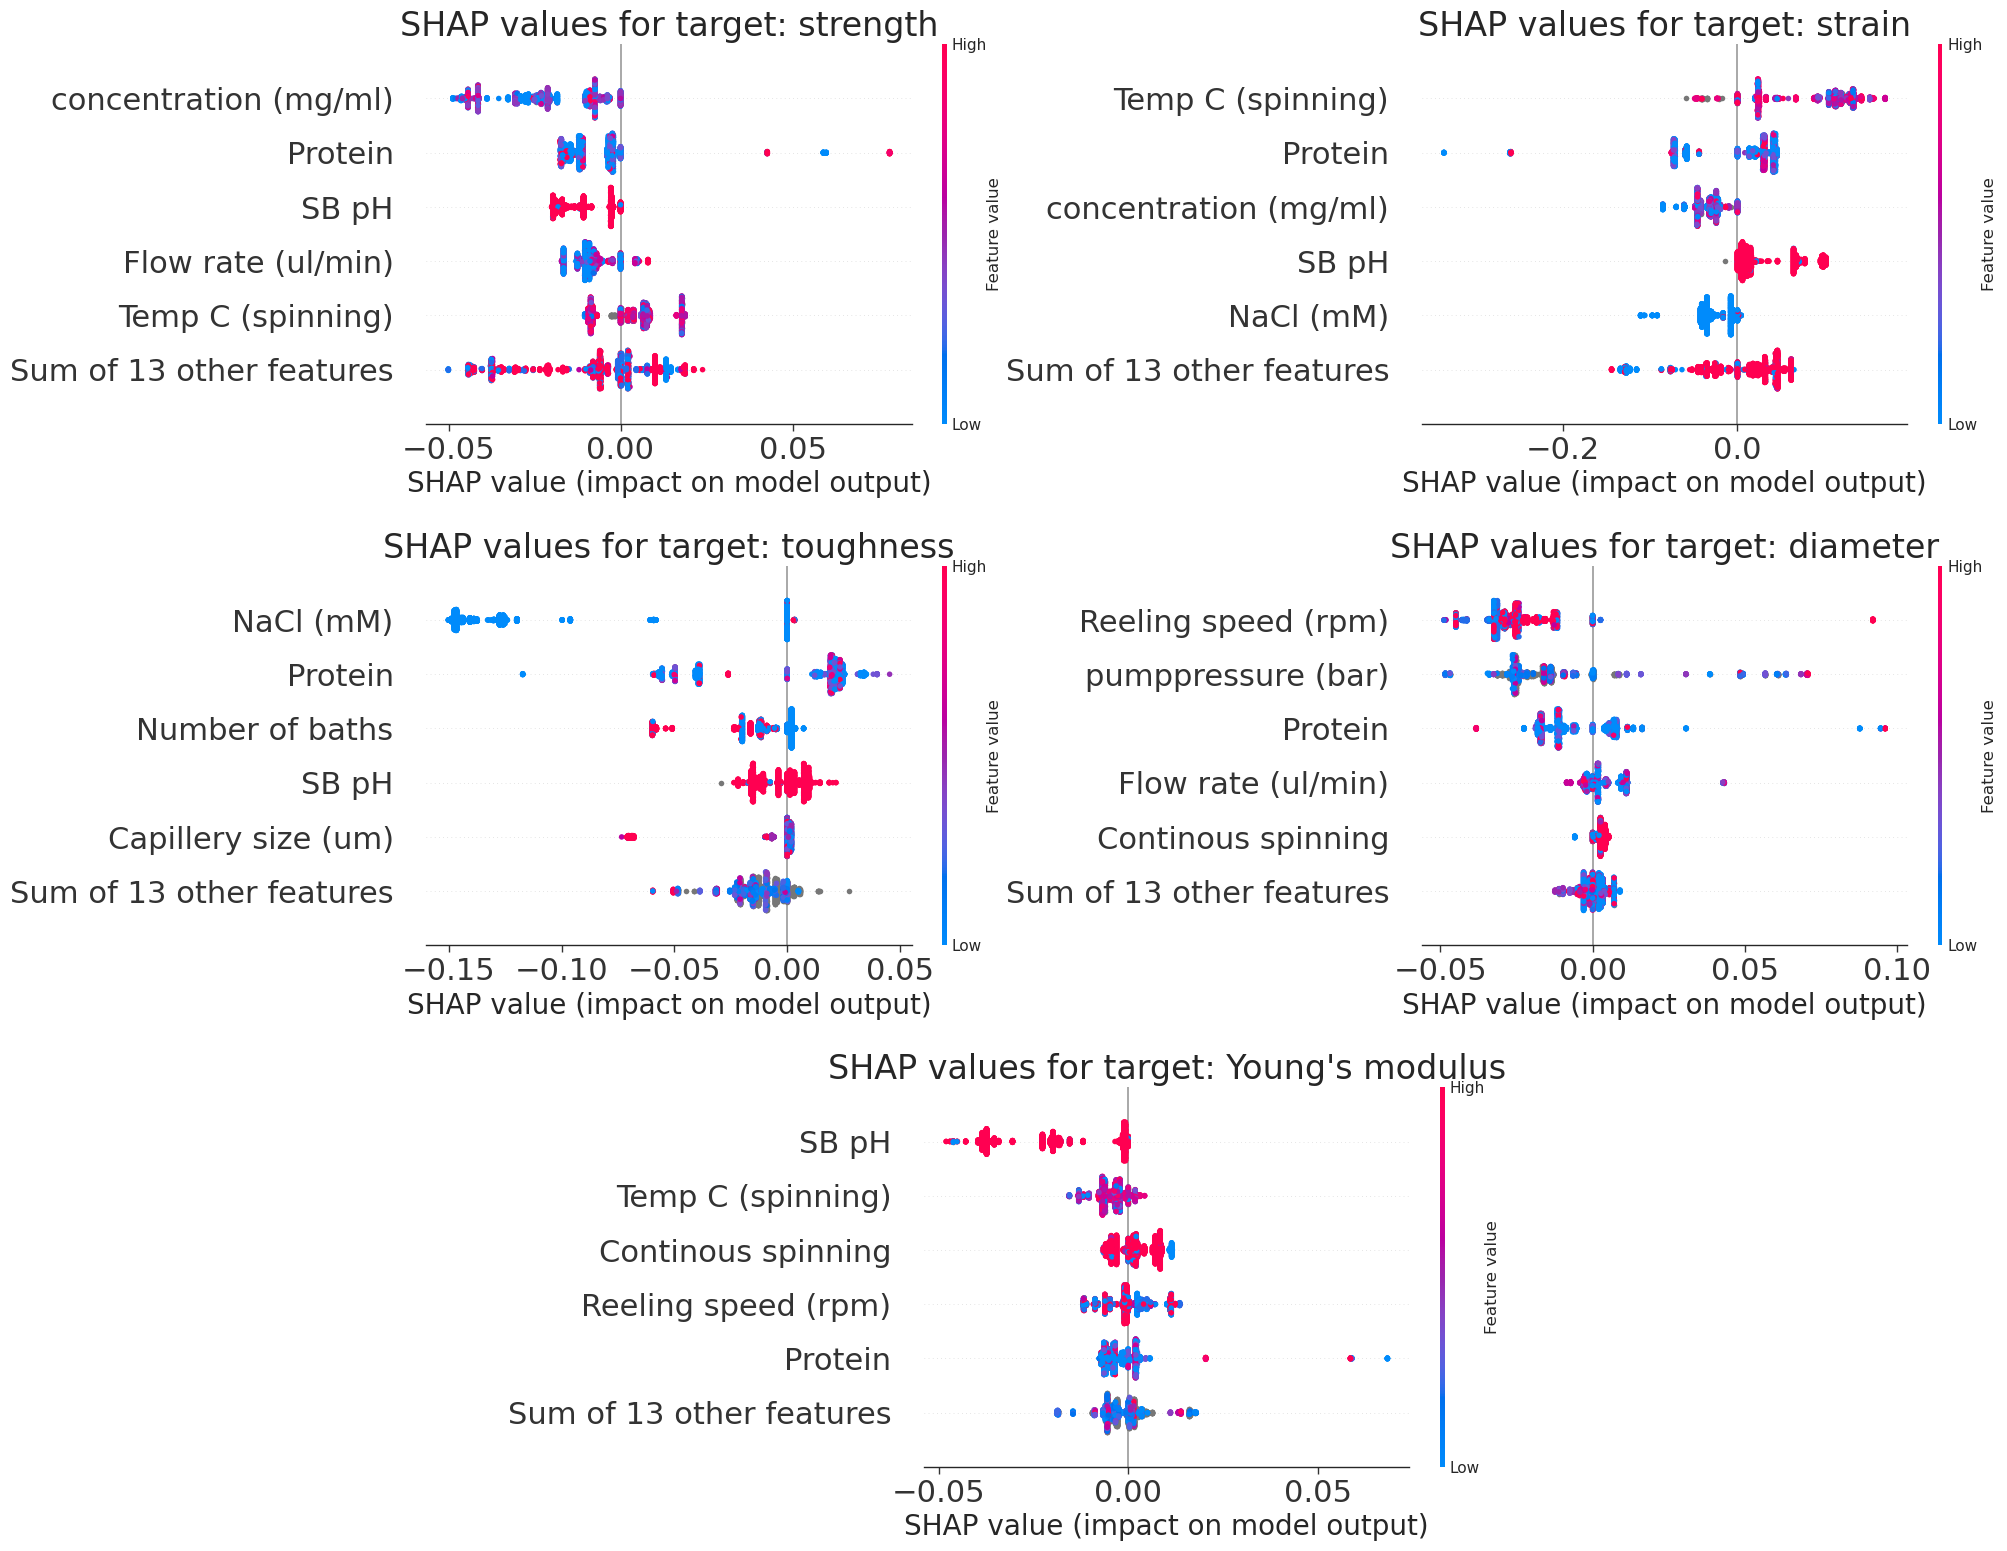

[<Axes: title={'center': 'SHAP values for target: strength'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': 'SHAP values for target: strain'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': 'SHAP values for target: toughness'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': 'SHAP values for target: diameter'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': "SHAP values for target: Young's modulus"}, xlabel='SHAP value (impact on model output)'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>]


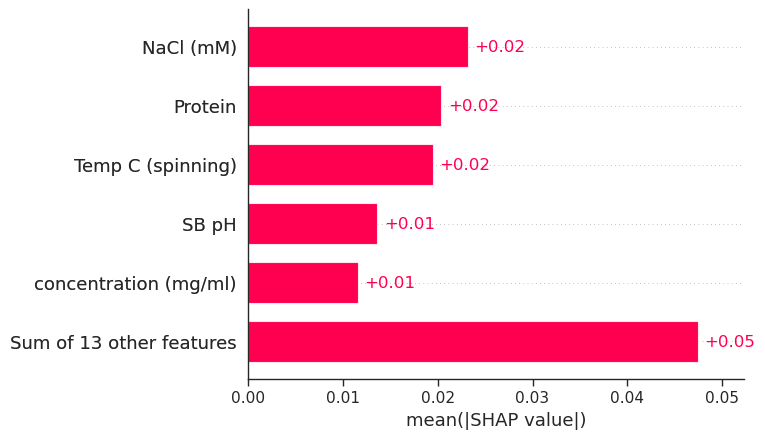

In [ ]:
format=True
if format:
    fig = plt.figure(figsize=(17,15))
    ax = [plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2),
        plt.subplot2grid((3,4), (0,2), colspan=2),
        plt.subplot2grid((3,4), (1,0), colspan=2),
        plt.subplot2grid((3,4), (1,2), colspan=2),
        plt.subplot2grid((3,4), (2,1), colspan=2)]
    fig.tight_layout(w_pad=24, h_pad=7)
else:
    fig, ax = plt.subplots(5,1)
    fig.set_figheight(25)

k = 'A'
max_display=6

X_encoded = [pd.DataFrame()] * n_folds
X_encoded_tot = X_tot[k].copy()
for fold in range(n_folds):
    X_encoded[fold] = X[k][fold].copy() 
    for col in ds[k].categorical_columns:  
        X_encoded[fold][col] = X_encoded[fold][col].astype("category")
        X_encoded[fold][col] = X_encoded[fold][col].cat.codes  # convert to integer codes
    for col in ds[k].numerical_columns:  
        X_encoded[fold][col] = X_encoded[fold][col].astype("float64")
for col in ds[k].categorical_columns:  
    X_encoded_tot[col] = X_encoded_tot[col].astype("category")
    X_encoded_tot[col] = X_encoded_tot[col].cat.codes  # convert to integer codes

target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
features = X_encoded_tot.to_numpy().astype('float64')
base_values = X_encoded_tot.to_numpy().mean(axis=0)

shap_values_avg = np.zeros(X_encoded_tot.shape)
# Loop over each target output
K = 5
top_features_tot_inds = set()
top_features = []
for i, target in enumerate(targets_ordered):
    shap_values = np.zeros(X_encoded_tot.shape)
    for fold in range(n_folds):
        # Compute SHAP values for the input data
        explainer = shap.Explainer(models[k][fold].estimators_[ds[k].target_columns.index(targets_ordered[i])])
        shap_values[fold*X_encoded[fold].shape[0] : (fold+1)*X_encoded[fold].shape[0]] = explainer(X_encoded[fold]).values
    shap_values_avg += np.abs(shap_values)

    top_inds = np.abs(shap_values).mean(axis=0).argsort()[-K:][::-1]
    top_features_tot_inds.update(top_inds)
    top_features.append(list(X_encoded_tot.columns[top_inds]))
    explanation = shap.Explanation(shap_values, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
    # Plot summary plot
    color_bar = True#i in [1,3,4]
    shap.plots.beeswarm(explanation, max_display=max_display, ax=ax[i], plot_size=None, show=False, color_bar=color_bar)
    ax[i].set_title(f"SHAP values for target: {target_names[i]}", fontsize=24)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.label.set_fontsize(20)
plt.show()
fig.savefig('../figures/SHAP.png', bbox_inches='tight')
print(fig.axes)

top_features_tot_inds = list(top_features_tot_inds)
top_features_tot = list(X_encoded_tot.columns[top_features_tot_inds])

shap_values_avg /= 5
fig, ax = plt.subplots()
explanation = shap.Explanation(shap_values_avg, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
shap.plots.bar(explanation, ax=ax, max_display=max_display, show=False)
plt.show()
fig.savefig('../figures/SHAP_bar.png')

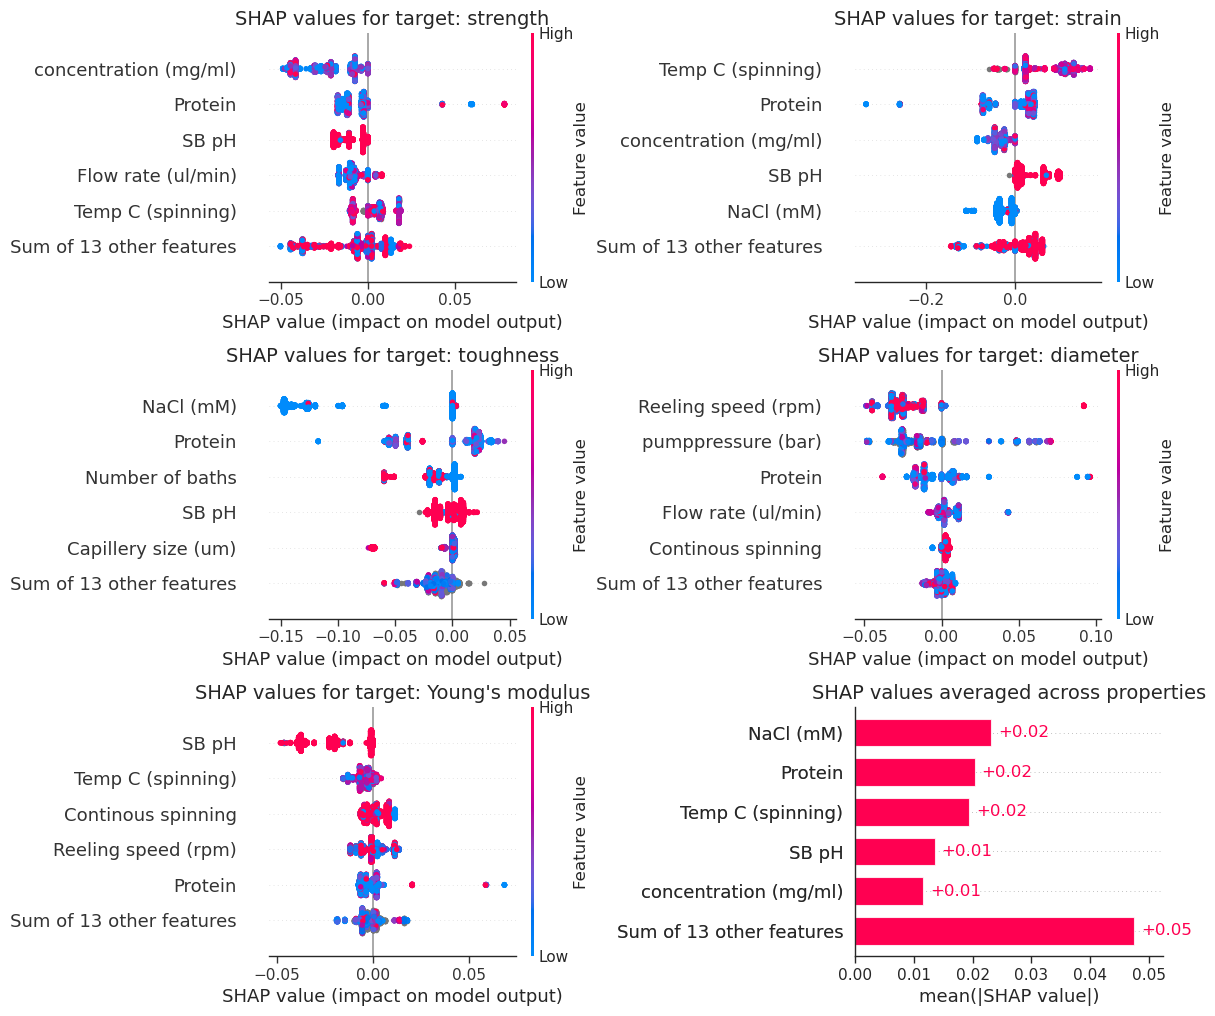

In [64]:
fig, ax = plt.subplots(3,2)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.tight_layout(w_pad=15, h_pad=3)

k = 'A'
max_display=6

X_encoded = [pd.DataFrame()] * n_folds
X_encoded_tot = X_tot[k].copy()
for fold in range(n_folds):
    X_encoded[fold] = X[k][fold].copy() 
    for col in ds[k].categorical_columns:  
        X_encoded[fold][col] = X_encoded[fold][col].astype("category")
        X_encoded[fold][col] = X_encoded[fold][col].cat.codes  # convert to integer codes
    for col in ds[k].numerical_columns:  
        X_encoded[fold][col] = X_encoded[fold][col].astype("float64")
for col in ds[k].categorical_columns:  
    X_encoded_tot[col] = X_encoded_tot[col].astype("category")
    X_encoded_tot[col] = X_encoded_tot[col].cat.codes  # convert to integer codes

target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
features = X_encoded_tot.to_numpy().astype('float64')
base_values = X_encoded_tot.to_numpy().mean(axis=0)

shap_values_avg = np.zeros(X_encoded_tot.shape)
# Loop over each target output
K = 5
top_features_tot_inds = set()
top_features = []
for i, target in enumerate(targets_ordered):
    shap_values = np.zeros(X_encoded_tot.shape)
    for fold in range(n_folds):
        # Compute SHAP values for the input data
        explainer = shap.Explainer(models[k][fold].estimators_[ds[k].target_columns.index(targets_ordered[i])])
        shap_values[fold*X_encoded[fold].shape[0] : (fold+1)*X_encoded[fold].shape[0]] = explainer(X_encoded[fold]).values
    shap_values_avg += np.abs(shap_values)

    top_inds = np.abs(shap_values).mean(axis=0).argsort()[-K:][::-1]
    top_features_tot_inds.update(top_inds)
    top_features.append(list(X_encoded_tot.columns[top_inds]))
    explanation = shap.Explanation(shap_values, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
    # Plot summary plot
    color_bar = True#i in [1,3,4]
    x = {0:0,1:0,2:1,3:1,4:2}[i]
    y = {0:0,1:1,2:0,3:1,4:0}[i]
    shap.plots.beeswarm(explanation, max_display=max_display, ax=ax[x][y], plot_size=None, show=False, color_bar=color_bar)
    ax[x][y].set_title(f"SHAP values for target: {target_names[i]}", fontsize=14)
    #ax[x][y].xaxis.set_tick_params(labelsize=10)
    #ax[x][y].yaxis.set_tick_params(labelsize=10)
    #ax[x][y].xaxis.label.set_fontsize(8)

top_features_tot_inds = list(top_features_tot_inds)
top_features_tot = list(X_encoded_tot.columns[top_features_tot_inds])

shap_values_avg /= 5
explanation = shap.Explanation(shap_values_avg, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
shap.plots.bar(explanation, ax=ax[-1][-1], max_display=max_display, show=False)
ax[-1][-1].set_title(f"SHAP values averaged across properties", fontsize=14)
plt.show()
fig.savefig('../figures/SHAP_combined.png')

In [28]:
print(top_features_tot)

['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH', 'NaCl (mM)', 'Capillery size (um)', 'Reeling speed (rpm)', 'Flow rate (ul/min)', 'pumppressure (bar)', 'Temp C (spinning)', 'Continous spinning']


In [29]:
print(top_features)

[['concentration (mg/ml)', 'Protein', 'SB pH', 'Flow rate (ul/min)', 'Temp C (spinning)'], ['Temp C (spinning)', 'Protein', 'concentration (mg/ml)', 'SB pH', 'NaCl (mM)'], ['NaCl (mM)', 'Protein', 'Number of baths', 'SB pH', 'Capillery size (um)'], ['Reeling speed (rpm)', 'pumppressure (bar)', 'Protein', 'Flow rate (ul/min)', 'Continous spinning'], ['SB pH', 'Temp C (spinning)', 'Continous spinning', 'Reeling speed (rpm)', 'Protein']]


In [30]:
# Top K features selected from SHAP ranking
#K = 10
#top_features_inds = shap_values_avg.mean(axis=0).argsort()[-K:][::-1]
#top_features = list(X_encoded_tot.columns[top_features_inds])

ds_ablation = Dataset(ds[k].df.loc[:, ['Sample number'] + top_features_tot + ds[k].target_columns], scaler=scaler)
params = [model.estimator.get_params() for model in models[k]]
models_ablation = mt.train_model(ds_ablation, params)


In [40]:
X_, Y = ds_ablation()
X_ablation = [None] * n_folds
metrics_ablation = [None] * n_folds
Y_ablation_pred = [None] * n_folds
for fold, (train_idx, test_idx) in enumerate(mt._outer_cv.split(X_, groups=ds['A'].sample_numbers)):
    X_ablation[fold] = X_.iloc[test_idx].copy()
    Y_ablation_pred[fold] = models_ablation[fold].predict(X_.iloc[test_idx].copy())
    metrics_ablation[fold] = compute_metrics(Y_true[fold], Y_ablation_pred[fold])
X_ablation_tot = pd.DataFrame(data=np.vstack(X_ablation), columns=X_.columns)
Y_ablation_pred_tot = pd.DataFrame(data=np.vstack(Y_ablation_pred), columns=Y.columns)
metrics_ablation_tot = compute_metrics(Y_true_tot, Y_ablation_pred_tot)
metrics_ablation_mean = pd.DataFrame(np.array(metrics_ablation).mean(axis=0), index=metrics_ablation[0].index, columns=metrics_ablation[0].columns)
metrics_ablation_std = pd.DataFrame(np.array(metrics_ablation).std(axis=0, ddof=1), index=metrics_ablation[0].index, columns=metrics_ablation[0].columns)

In [41]:
metrics_ablation_tot

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.076414,0.218309,0.097708,0.071360,0.157013
MAE,0.050878,0.167759,0.070327,0.053069,0.121274
$R^2$,0.507938,0.301972,0.265026,0.042168,0.179127
PCC,0.712835,0.549931,0.516590,0.242818,0.437639


In [42]:
metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075816,0.210384,0.098670,0.070883,0.156149
MAE,0.050536,0.161301,0.070845,0.052791,0.120265
$R^2$,0.515603,0.351730,0.250484,0.054926,0.188137
PCC,0.718113,0.593213,0.506631,0.261661,0.445117


In [77]:
100 * metrics_ablation_tot / metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,100.788103,103.766767,99.025161,100.672698,100.553376
MAE,100.676275,104.003269,99.268332,100.527245,100.838917
$R^2$,98.513354,85.853504,105.805515,76.772675,95.210849
PCC,99.264949,92.703720,101.965607,92.798678,98.319807


In [91]:
pvals = pd.Series(data=wilcoxon(Y_pred_tot['A'], Y_ablation_pred_tot).pvalue, index=Y_true_tot.columns)
print(pvals)
print()
print(pvals.to_latex())

Diameter (µm)                 0.777254
Strain (mm/mm)                0.086305
Strength (MPa)                0.786907
Youngs Modulus (GPa)          0.801081
Toughness Modulus (MJ m-3)    0.973113
dtype: float64

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Diameter (µm) & 0.777254 \\
Strain (mm/mm) & 0.086305 \\
Strength (MPa) & 0.786907 \\
Youngs Modulus (GPa) & 0.801081 \\
Toughness Modulus (MJ m-3) & 0.973113 \\
\bottomrule
\end{tabular}



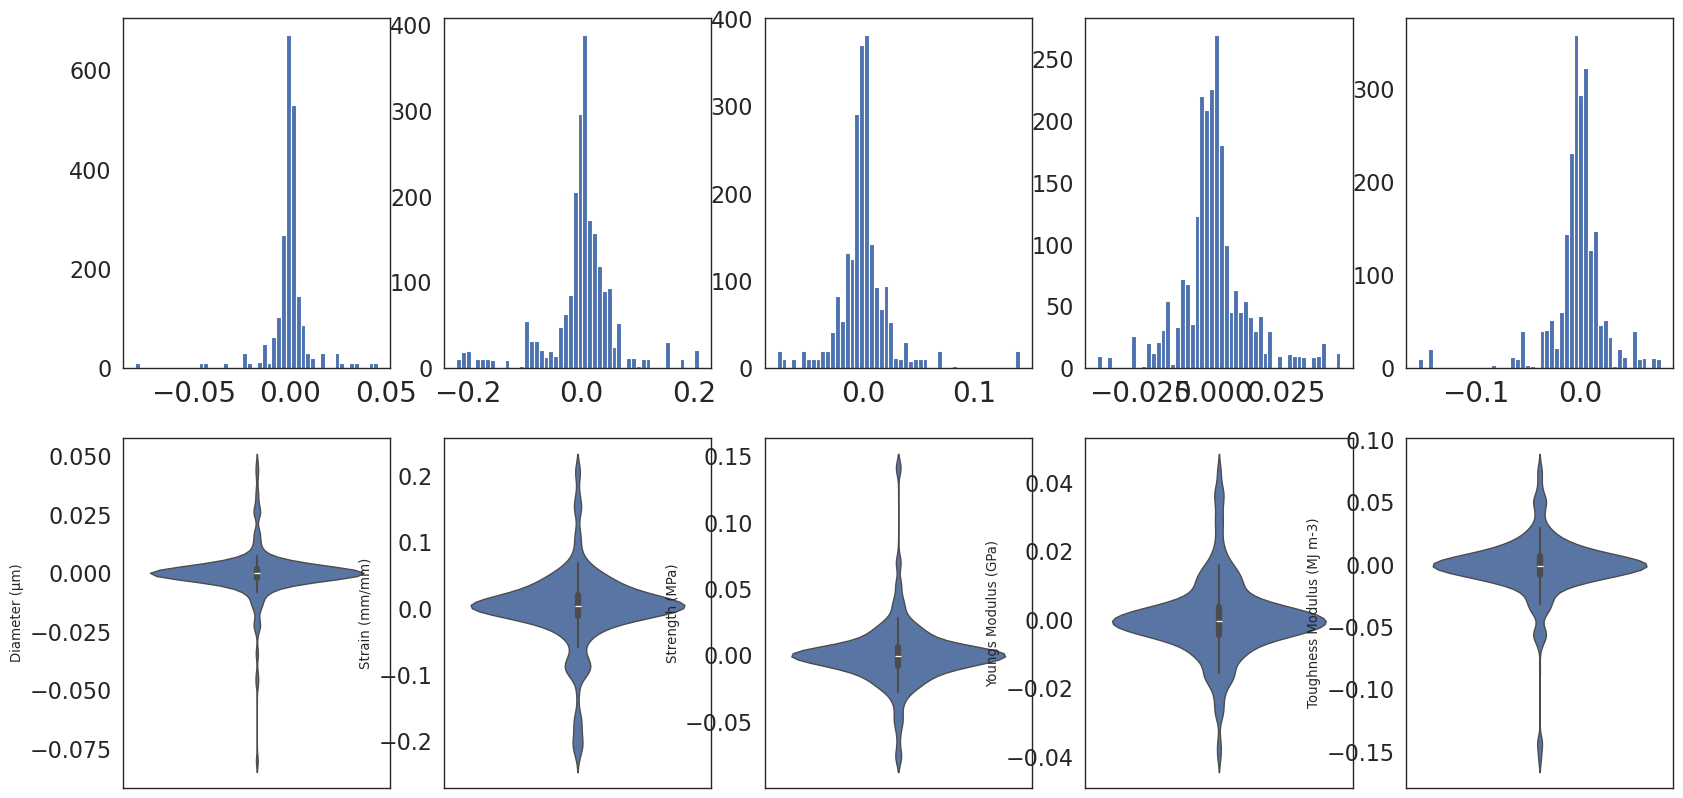

NormaltestResult(statistic=array([ 942.5363153 ,  339.962638  ,  894.08576927,  242.1083261 ,
       1065.60233143]), pvalue=array([2.14209948e-205, 1.50678446e-074, 7.10791180e-195, 2.67205243e-053,
       4.04942889e-232]))
TtestResult(statistic=array([-0.12473004, -0.0507489 ,  0.201674  ,  0.40977784, -0.76188453]), pvalue=array([0.900743  , 0.95952793, 0.84018096, 0.68198897, 0.44616996]), df=array([4378., 4378., 4378., 4378., 4378.]))
WilcoxonResult(statistic=array([1170517., 1026676., 1160393., 1161289., 1138189.]), pvalue=array([3.26216874e-01, 5.15681597e-09, 1.85555277e-01, 1.95814682e-01,
       3.80701387e-02]))


In [78]:
fig, ax = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(10)
diff = Y_pred_tot['A'] - Y_ablation_pred_tot
for i in range(5):
    ax[0][i].hist(diff.iloc[:, i], bins=50)
    sns.violinplot(ax=ax[1][i], data=diff.iloc[:, i], bw_method='scott')
plt.show()
print(normaltest(Y_pred_tot['A'] - Y_ablation_pred_tot))

result = ttest_ind(Y_pred_tot['A'], Y_ablation_pred_tot)
print(result)

print(wilcoxon(Y_pred_tot['A'], Y_ablation_pred_tot))

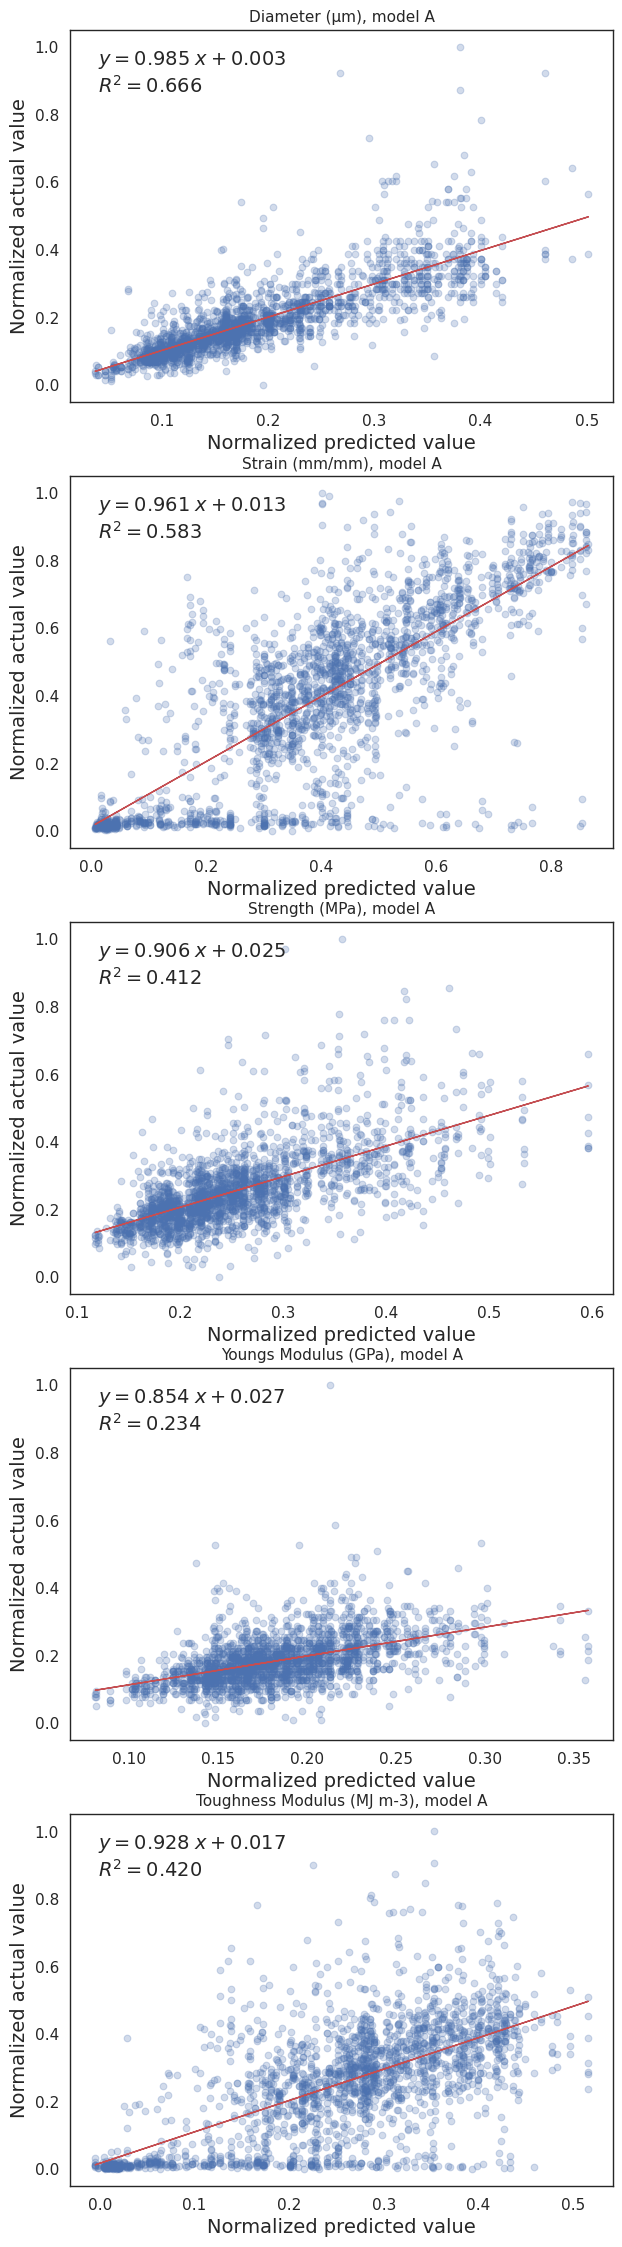

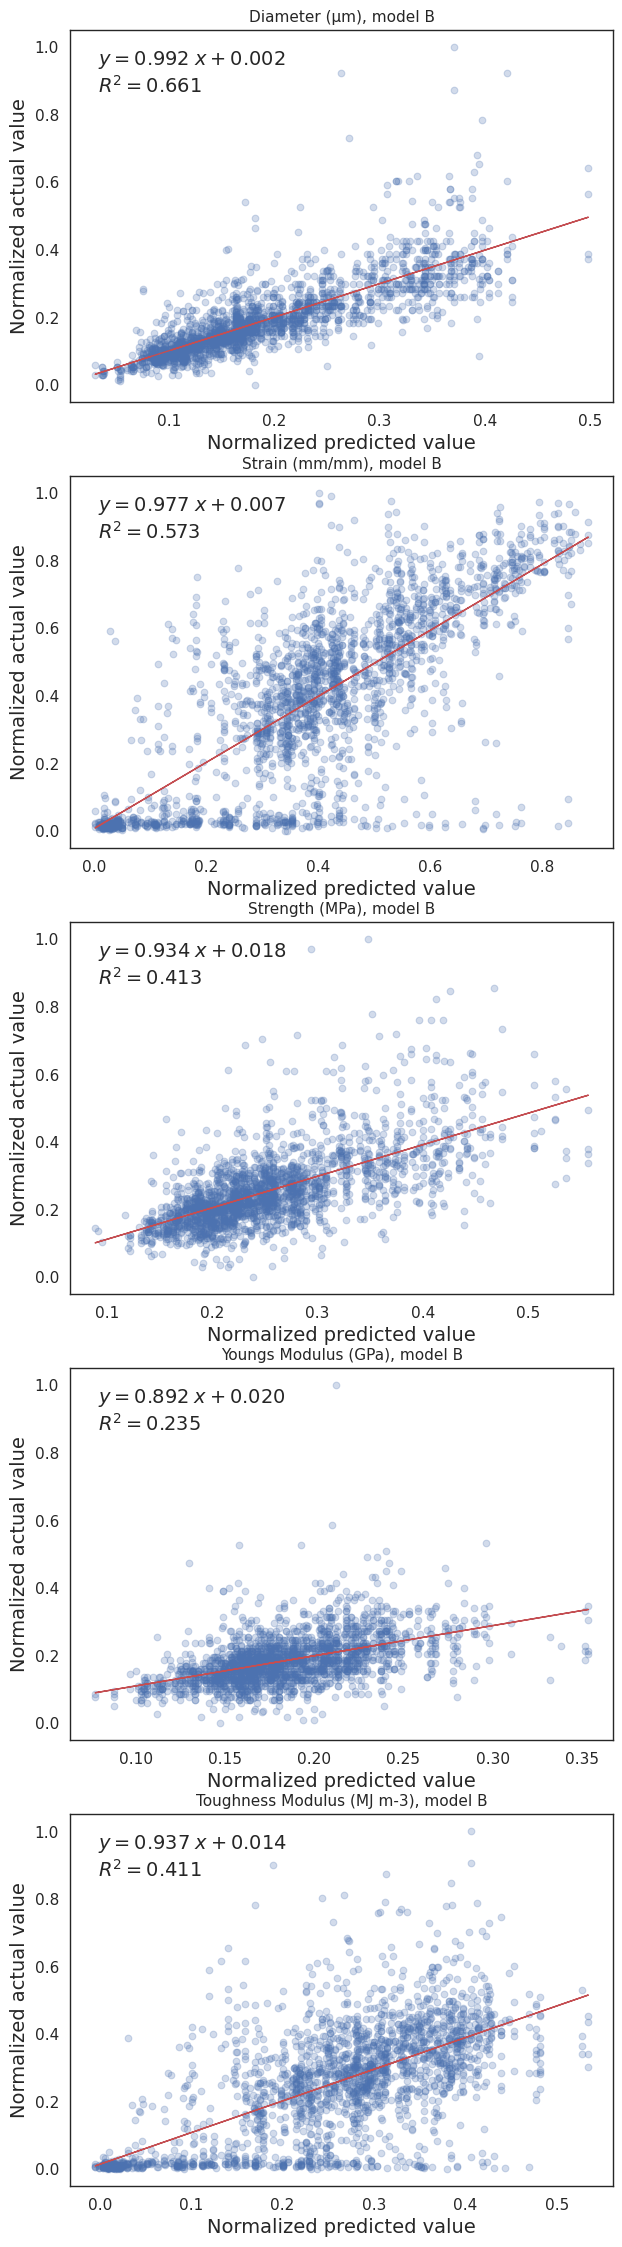

In [72]:
for k in 'A', 'B':
    fig, axs = plt.subplots(5, 1)
    fig.set_figheight(28)
    fig.set_figwidth(7)
    for i in range(5):
        col = ds[k].target_columns[i]
        x = Y_pred_tot[k].to_numpy()[:,i]
        y = Y_true_tot.to_numpy()[:,i]
        z = np.polyfit(x, y, 1)
        y_hat = np.poly1d(z)(x)
        axs[i].set_title(f'{col}, model {k}')
        axs[i].set_xlabel('Normalized predicted value')
        axs[i].set_ylabel('Normalized actual value')
        axs[i].scatter(x, y, c='b', alpha=.25)
        axs[i].plot(x, y_hat, "r-", lw=1)
        text = r"$y={:0.3f}\;x+{:0.3f}$".format(z[0], z[1]) + "\n" + r"$R^2 = {:0.3f}$".format(metrics_mean[k].loc['$R^2$', col])
        axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes,
        fontsize=14, verticalalignment='top')
    fig.savefig(f'../figures/scatter_{k}.png')
    plt.show()

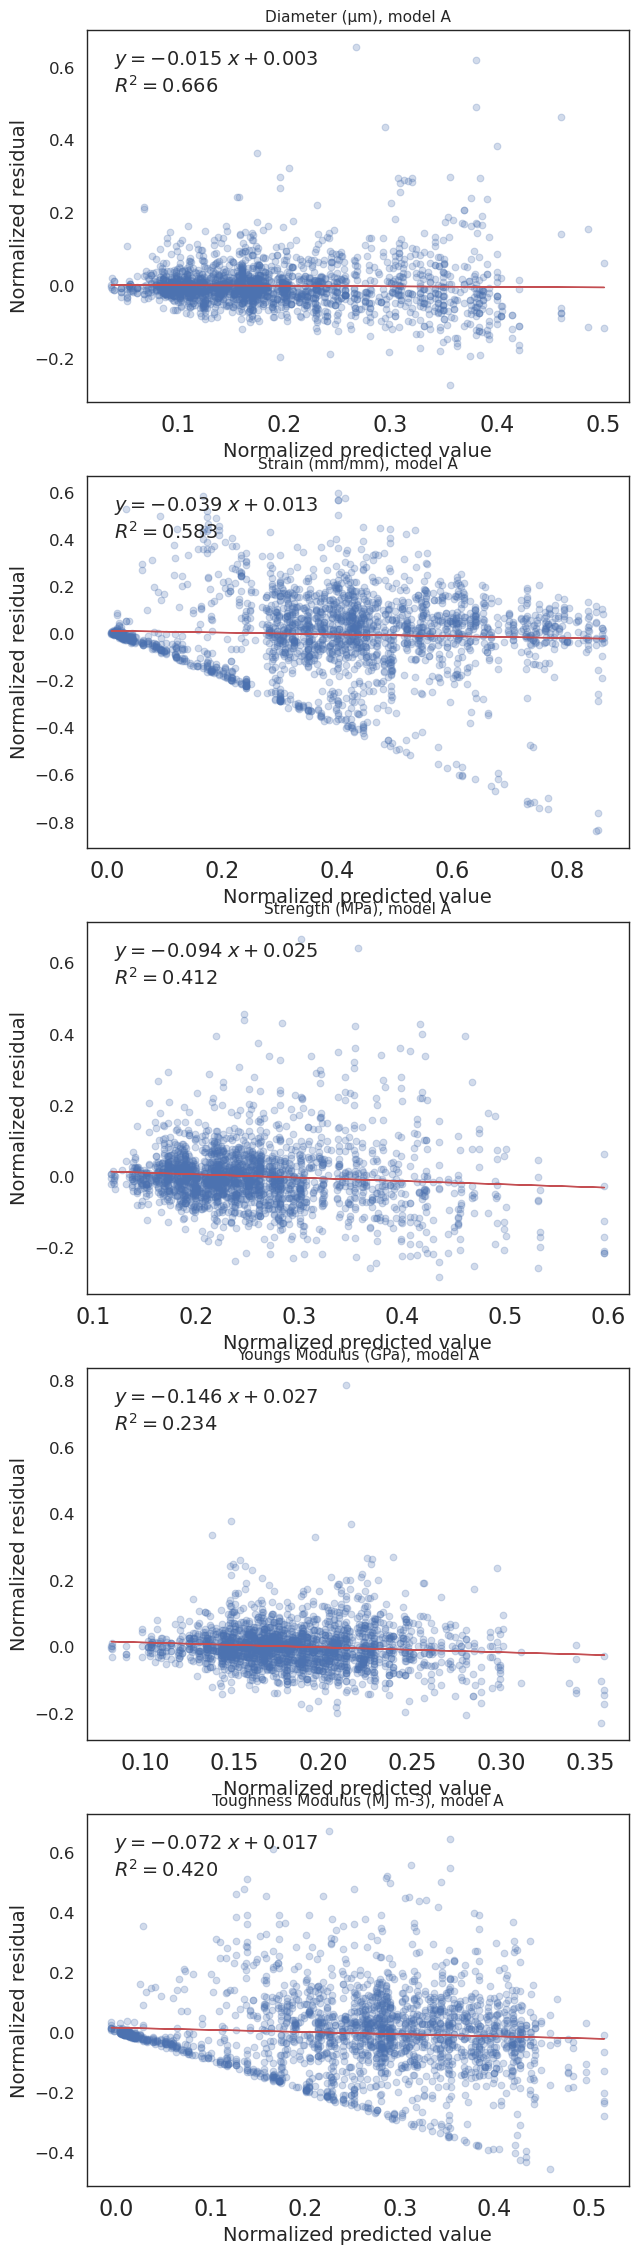

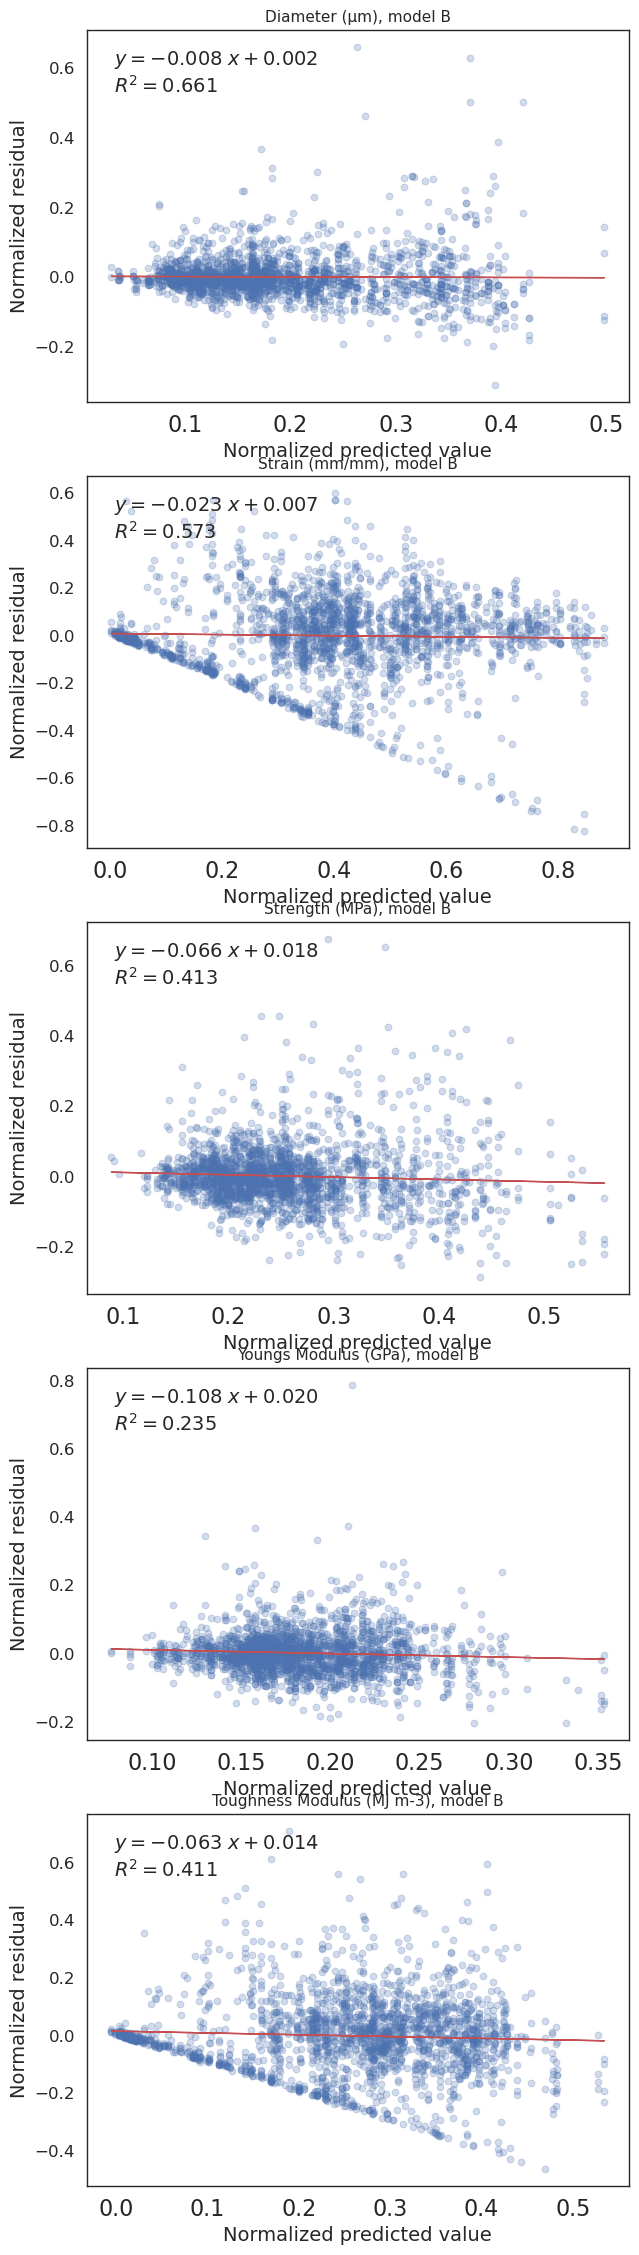

In [ ]:
for k in 'A', 'B':
    fig, axs = plt.subplots(5, 1)
    fig.set_figheight(28)
    fig.set_figwidth(7)
    for i in range(5):
        col = ds[k].target_columns[i]
        x = Y_pred_tot[k].to_numpy()[:,i]
        y = Y_true_tot.to_numpy()[:,i] - Y_pred_tot[k].to_numpy()[:,i]
        z = np.polyfit(x, y, 1)
        y_hat = np.poly1d(z)(x)
        axs[i].set_title(f'{col}, model {k}')
        axs[i].set_xlabel('Normalized predicted value')
        axs[i].set_ylabel('Normalized residual')
        axs[i].scatter(x, y, c='b', alpha=.25)
        axs[i].plot(x, y_hat, "r-", lw=1)
        text = r"$y={:0.3f}\;x+{:0.3f}$".format(z[0], z[1]) + "\n" + r"$R^2 = {:0.3f}$".format(metrics_mean[k].loc['R2', col])
        axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes,
        fontsize=14, verticalalignment='top')
    fig.savefig(f'../figures/residual_{k}.png')
    plt.show()